In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
plt.ion()

In [4]:
# data transform
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
data_dir = 'Data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

In [6]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [7]:
class_names

['COVID-19', 'Normal', 'Pnemonia_others', 'non-COVID-19']

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    train_acc = []
    valid_acc = []
    train_loss = []
    valid_loss = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
#            if phase == 'train':
#                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc, train_loss, valid_acc, valid_loss

In [18]:
vgg16 = models.vgg16(pretrained=True)

In [19]:
num_classes = 4
for param in vgg16.parameters():
    param.requires_grad = False
vgg16.classifier = nn.Sequential(nn.Linear(in_features=25088, out_features=4096, bias=True),
                                 nn.ReLU(inplace=True),
                                 nn.Dropout(p=0.5, inplace=False),
                                 nn.Linear(in_features=4096, out_features=4096, bias=True),
                                 nn.ReLU(inplace=True),
                                 nn.Dropout(p=0.5, inplace=False),
                                 nn.Linear(in_features=4096, out_features=num_classes, bias=True)
                                )

In [20]:
vgg16


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [21]:
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Observe that all parameters are being optimized
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [22]:
vgg16, train_acc, train_loss, valid_acc, valid_loss = train_model(vgg16,
                                        criterion, optimizer,exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.9655 Acc: 0.5846
val Loss: 0.8970 Acc: 0.6148

Epoch 1/24
----------
train Loss: 0.8116 Acc: 0.6539
val Loss: 0.5878 Acc: 0.7550

Epoch 2/24
----------
train Loss: 0.7546 Acc: 0.6819
val Loss: 0.6393 Acc: 0.7125

Epoch 3/24
----------
train Loss: 0.7340 Acc: 0.6856
val Loss: 0.5718 Acc: 0.7635

Epoch 4/24
----------
train Loss: 0.7064 Acc: 0.6999
val Loss: 0.5913 Acc: 0.7529

Epoch 5/24
----------
train Loss: 0.6904 Acc: 0.7122
val Loss: 0.5511 Acc: 0.7747

Epoch 6/24
----------
train Loss: 0.6810 Acc: 0.7159
val Loss: 0.5439 Acc: 0.7763

Epoch 7/24
----------
train Loss: 0.6601 Acc: 0.7318
val Loss: 0.5496 Acc: 0.7721

Epoch 8/24
----------
train Loss: 0.6571 Acc: 0.7284
val Loss: 0.5591 Acc: 0.7816

Epoch 9/24
----------
train Loss: 0.6394 Acc: 0.7309
val Loss: 0.5217 Acc: 0.7731

Epoch 10/24
----------
train Loss: 0.6399 Acc: 0.7407
val Loss: 0.5769 Acc: 0.7689

Epoch 11/24
----------
train Loss: 0.6365 Acc: 0.7391
val Loss: 0.5312 Acc: 0.7965

Ep

In [13]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [25]:
predicted = []
labels = []
for data, label in dataloaders["val"]:
    outputs = vgg16(data)
    _, preds = torch.max(outputs, 1)
    labels.extend(label.tolist())
    predicted.extend(preds.tolist())
print(len(predicted))
print(len(labels))

1882
1882


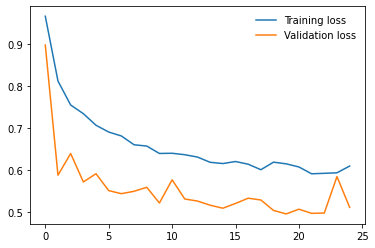

In [23]:
plt.plot(train_loss, label='Training loss')
plt.plot(valid_loss, label='Validation loss')
plt.legend(frameon=False)
plt.show()

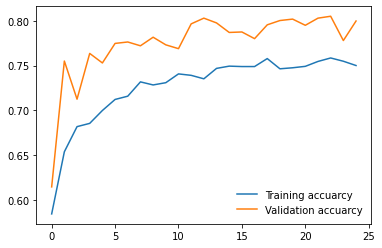

In [26]:
plt.plot(train_acc, label='Training accuarcy')
plt.plot(valid_acc, label='Validation accuarcy')
plt.legend(frameon=False)
plt.show()

In [30]:
from sklearn.metrics import classification_report, confusion_matrix

In [29]:
print(classification_report(labels, predicted, target_names=class_names))

                 precision    recall  f1-score   support

       COVID-19       0.78      0.96      0.86       112
         Normal       0.85      0.95      0.90       479
Pnemonia_others       0.75      0.55      0.63       451
   non-COVID-19       0.80      0.84      0.82       840

       accuracy                           0.80      1882
      macro avg       0.79      0.83      0.80      1882
   weighted avg       0.80      0.80      0.80      1882



In [50]:
cmf = confusion_matrix(labels,predicted,normalize="true")

In [51]:
cmf

array([[0.96428571, 0.01785714, 0.        , 0.01785714],
       [0.00208768, 0.9519833 , 0.03131524, 0.01461378],
       [0.00665188, 0.08425721, 0.54545455, 0.36363636],
       [0.03214286, 0.04642857, 0.08214286, 0.83928571]])

In [52]:
import pandas as pd
cmf = pd.DataFrame(cmf, 
  index = class_names,
  columns = class_names)

In [53]:
import seaborn as sns

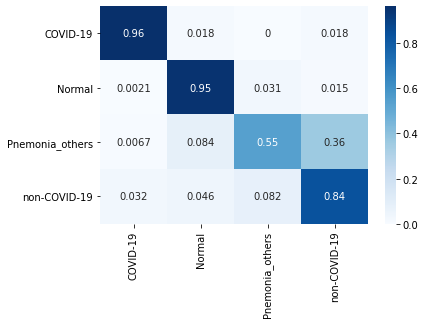

In [54]:
sns.heatmap(cmf, cmap='Blues',annot=True)